# Double and Pseudo Double source plane cosmology forecast

In [1]:
# --- Standard Library ---
import copy
import os
from copy import deepcopy
from itertools import combinations
from multiprocessing import Pool, cpu_count

# --- Scientific / Numerical ---
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import corner

# --- Astropy ---
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity

# --- SLSim ---
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
import slsim.Sources as sources
from slsim.Lenses.lens import Lens
from slsim.Lenses.lens_pop import LensPop
from slsim.LOS.los_pop import LOSPop
from slsim.Plots.lens_plots import LensingPlots

# --- Lenstronomy / HierArc ---
import emcee
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

# --- ChainConsumer ---
from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth
from chainconsumer.plotting import plot_contour

# --- Local Utilities ---
from utils import normalize_data, get_pairs_table_PDSPL, kdtree_matching_n_dim, draw_lens_from_given_zs

# --- Matplotlib Style ---
plt.style.use("paper_style.mplstyle")

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
/Users/paras/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/paras/Projects/repos/self/slsim/slsim/Plots/lens_plots.py:5: UserWarning: If you want to simulate images with Roman filters, please install the galsim module.
Note that this module is not supported on Windows
  from slsim.ImageSimulation.roman_image_simulation import simulate_roman_image


In [2]:
POSTERIOR_DIR = "../data/posteriors/"
FIGURES_DIR = "../figures/forecasts/"

## Prepare LSST like samples for Single Visit, Y10, and 4MOST 

In [3]:
########################################################
### Load the GGL data table and apply selection cuts!
########################################################

sky_area = "20000.0"
GGL_data_table = Table.read(f"../data/FULL_LSST/GGL_{sky_area}_SQDEG_NON_SIS.fits", format='fits')

contrast_mask = np.zeros(len(GGL_data_table), dtype=bool)
# ps_magnification_mask = np.zeros(len(GGL_data_table), dtype=bool)
for i in range(len(GGL_data_table)):
    
    # contrast mask
    all_vals = GGL_data_table['contrast_ratio_i'][i]
    all_vals = all_vals[~np.isnan(all_vals)]
    # get linear scale values
    all_vals = 10**(-0.4 * all_vals)
    contrast_mask[i] = np.all(all_vals > 2) # all images should have contrast ratio > 2

    # point source magnification mask
    # ps_magnifications = GGL_data_table['ps_magnification'][i]
    # ps_magnifications = ps_magnifications[~np.isnan(ps_magnifications)]
    # high_mag = np.any(np.abs(ps_magnifications) > 3)
    # ps_magnification_mask[i] = high_mag

# add a column for r_band lensed source magnitude
GGL_data_table['mag_S_r_lensed'] = GGL_data_table['mag_S_r'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))
GGL_data_table['mag_S_i_lensed'] = GGL_data_table['mag_S_i'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))

# add g-r and r-i colors for deflector
GGL_data_table['color_D_gr'] = GGL_data_table['mag_D_g'] - GGL_data_table['mag_D_r']
GGL_data_table['color_D_ri'] = GGL_data_table['mag_D_r'] - GGL_data_table['mag_D_i']

# add log columns
GGL_data_table['log_R_e_kpc'] = np.log10(GGL_data_table['R_e_kpc'])
GGL_data_table['log_Sigma_half_Msun/pc2'] = np.log10(GGL_data_table['Sigma_half_Msun/pc2'])
GGL_data_table['log_sigma_v_D'] = np.log10(GGL_data_table['sigma_v_D'])

GGL_data_table = GGL_data_table[ 
                                # (GGL_data_table['mag_D_i'] >= 19) & # optional, but reasonable for realistic deflectors
                                (GGL_data_table['mag_S_i_lensed'] < 28)
                                & (GGL_data_table['mag_D_i'] < 28)
                                & (contrast_mask)
                                & (np.abs(GGL_data_table['es_magnification']) > 3)
                                # & (ps_magnification_mask)
                                ]

GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2,num_images,contrast_ratio_i,contrast_ratio_r,contrast_ratio_g,contrast_ratio_z,contrast_ratio_y,ps_magnification,es_magnification,R_e_arcsec,mag_S_r_lensed,mag_S_i_lensed,color_D_gr,color_D_ri,log_R_e_kpc,log_Sigma_half_Msun/pc2,log_sigma_v_D
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,0.329124822435322,1.0051241911718725,0.7363886012965237,204.95721128465118,275998973063.0321,25.94413434762533,26.446866065929875,26.901160154345234,25.41608564735612,25.198691277756744,18.473213998207086,18.998168679136697,20.326978780985307,18.18745500089087,18.017140693630708,0.6211472127946348,-0.09393377584227298,-0.16505803588587262,0.18991500586970056,2.321328016088915,2.9465977208867837,8535.89328257733,21.757217663234215,2,[-2.4220773 -1.28337688 nan nan],[-2.44430027 -1.30559985 nan nan],[-3.31881628 -2.18011586 nan nan],[-2.66436701 -1.52566659 nan nan],[-2.71144707 -1.57274665 nan nan],[ 2.92207111 -1.07341961 nan nan],4.173255766980806,0.6211472127946348,24.895678560426354,24.39294684212181,1.3288101018486103,0.5249546809296106,0.46932084860040457,3.9312489768150187,2.3116632032869937
2,1.5396965757178396,4.066533840144556,0.5933648988866821,231.10867185666163,389289198801.96466,24.900236495349702,24.922141654357382,25.763978022146283,24.725872734929496,24.683270988046196,24.41195843790899,25.130329765942452,25.30026978999013,23.730460832500615,23.255917419169965,0.28476868766254126,-0.06688414245898035,-0.07483269760643144,0.10036643434699066,1.9636670626037047,2.4116322493391453,9733.655223494123,25.046405207401236,2,[-6.91412895 -4.66572158 nan nan],[-7.61059512 -5.36218775 nan nan],[-6.93869877 -4.69029141 nan nan],[-6.4069951 -4.15858774 nan nan],[-5.97505344 -3.72664607 nan nan],[ 2.92800817 -1.97668935 nan nan],5.071634728656454,0.28476868766254126,23.159271736692816,23.137366577685135,0.16994002404767627,0.7183713280334629,0.3823110827967278,3.988275959003662,2.363816241752744
3,0.8225987025699782,2.366507264296516,0.9668295355099917,259.62963891734057,542551704224.9811,25.42476006841597,25.666408789606926,26.01763736223713,25.216602806393354,24.925045335560704,21.013526126833924,22.171608359503182,23.605021431468003,20.288169411022842,20.01538502099843,0.4462983000792573,-0.00861094230919072,0.1274912291350796,0.1277816960046531,1.835514582302274,3.382329505014604,7244.8980947256905,24.32302122251722,2,[-4.65708854 -2.21916653 nan nan],[-5.57352205 -3.13560004 nan nan],[-6.65570655 -4.21778454 nan nan],[-4.13988909 -1.70196708 nan nan],[-4.15866217 -1.72074016 nan nan],[ 4.24962347 -1.70365791 nan nan],6.3961411913084785,0.4462983000792573,23.651613684625712,23.409964963434756,1.4334130719648215,1.1580822326692584,0.5292159140952236,3.8600322811516294,2.4143542693436544
5,1.5171235169191208,2.5465475424063917,0.6723012778010724,303.7585859107459,810824890889.5197,25.019755560697423,25.16387716380412,25.26612378578275,25.065684701825038,24.946643206818198,23.480512006952782,24.623619500693746,25.16421667728064,22.744252502352037,22.077746297186646,0.9863277959653846,-0.11291634955715528,-0.1482659157157352,0.1863676038380576,1.9241066977496035,8.34989790387258,4966.993360524251,27.601580718709098,2,[-5.37082001 -3.52830932 nan nan],[-6.3698059 -4.52729521 nan nan],[-6.80815645 -4.96564577 nan nan],[-4.58863136 -2.74612068 nan nan],[-4.04116665 -2.19865597 nan nan],[ 4.03371445 -0.99858105 nan nan],6.800722117078591,0.9863277959653844,23.082489589828263,22.938367986721566,0.5405971765868927,1.1431074937409633,0.9216811652972743,3.69609357946580

In [4]:
########################################################
### Apply LSST magnitude depth cuts and produce pdspl_samples
########################################################

########################################################
# single exposure
# point source depths: g < 26.0, r < 25.7, i < 25.0, z < 24.3, y < 23.1
# extended source depths are 1 mag shallower: g < 25.0, r < 24.7, i < 24.0, z < 23.3, y < 22.1

# 10 year coadd
# point source depths: g < 27.4, r < 27.5, i < 26.8, z < 26.1, y < 24.9
# extended source depths are 1 mag shallower: g < 26.4, r < 26.5, i < 25.8, z < 25.1, y < 23.9

# 4MOST spec-z : r < 23.5 and z_S < 1.5

# 4MOST sigma_v_D : 50% of the spec-z sample will have sigma_v_D measurements, Collett et al 2023 [https://www.eso.org/sci/publications/messenger/archive/no.190-mar23/messenger-no190-49-52.pdf]
########################################################

# Define all LSST sample configurations in one structured dictionary
pdspl_samples = {
    # "slsim_20K_deg_sq.": {
    #     "mask": np.ones(len(GGL_data_table), dtype=bool),
    #     "title": f"SLSim Full Sample ({sky_area} deg$^2$)",
    #     "label": "SLSim Full Sample",
    #     "color": "tab:blue",
    #     "desc": "SLSim full sample; extended-source $i < 28.0$",
    #     "selc_func_latex": "$m_{i} < 28.0$"
    # },
    "lsst_single_visit": {
        "mask": (
            (GGL_data_table["mag_D_i"] < 24.0)
            & (GGL_data_table["mag_S_i_lensed"] < 24.0)
        ),
        "title": f"LSST Single Visit Depth ({sky_area} deg$^2$)",
        "label": "LSST SINGLE ($i < 24.0$)",
        "name": "LSST SINGLE",
        "color": "tab:orange",
        "desc": "Single exposure; extended-source $i < 24.0$",
        "selc_func_latex": "$m_{i} < 24.0$"
    },

    "lsst_y10": {
        "mask": (
            (GGL_data_table["mag_D_i"] < 25.8)
            & (GGL_data_table["mag_S_i_lensed"] < 25.8)
        ),
        "title": f"LSST 10-year Coadd Depth ({sky_area} deg$^2$)",
        "label": "LSST Y10 ($i < 25.8$)",
        "name": "LSST Y10",
        "color": "tab:green",
        "desc": "10-year coadd; extended-source $i < 25.8$",
        "selc_func_latex": "$m_{i} < 25.8$"
    },

    "lsst_4most_spec-z": {
        "mask": (
            (GGL_data_table["mag_S_r_lensed"] < 24.0) &
            (GGL_data_table["z_S"] < 1.5)
        ),
        "title": f"LSST + 4MOST spec-z Sample ({sky_area} deg$^2$)",
        "label": "LSST Y10 + 4MOST ($r < 24, z_S < 1.5$)",
        "name": "LSST Y10 + 4MOST (spec-z)",
        "color": "tab:red",
        "desc": "Spectroscopic 4MOST limit; $r < 24, z_S < 1.5$",
        "selc_func_latex": "$m_{r} < 24.0, z_S < 1.5$"
    },

    "lsst_4most_spec-z_sigma_v": {
        "mask": None,  # to be filled later, # half of the 4MOST spec-z sample will have sigma_v measurements
        "title": f"LSST + 4MOST spec-z + "+"$\\sigma_{v, D}$"+f" Sample ({sky_area} deg$^2$)",
        "label": "LSST Y10 + 4MOST ($r < 24, z_S < 1.5$)",
        "name": "LSST Y10 + 4MOST (spec-z + $\\sigma_{v, D}$)",
        "color": "tab:red",
        "desc": "Spectroscopic 4MOST limit; $r < 24, z_S < 1.5$",
        "selc_func_latex": "$m_{r} < 24.0, z_S < 1.5$"
    },
}

# Build filtered tables
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        org_mask = pdspl_samples['lsst_4most_spec-z']["mask"]
        selected_indices = np.random.choice(np.argwhere(org_mask).flatten(), size = org_mask.sum() // 2, replace = False)
        new_mask = np.zeros(len(GGL_data_table), dtype=bool)
        new_mask[selected_indices] = True
        s["mask"] = new_mask

    s["table"] = GGL_data_table[s["mask"]]
    s["count"] = len(s["table"])

# Summary
print('-'*80)
print(f"Sky area: {sky_area} deg^2")
print('-'*80)
print(f"SLSim (i < 28, contrast_ratio > 2, mu_tot > 3, theta_E > 1\")  # lenses: {len(GGL_data_table)}")

for key, s in pdspl_samples.items():
    print(f"{s['name']:<62}# lenses: {s['count']}")

print('-'*80)


--------------------------------------------------------------------------------
Sky area: 20000.0 deg^2
--------------------------------------------------------------------------------
SLSim (i < 28, contrast_ratio > 2, mu_tot > 3, theta_E > 1")  # lenses: 322403
LSST SINGLE                                                   # lenses: 188902
LSST Y10                                                      # lenses: 319925
LSST Y10 + 4MOST (spec-z)                                     # lenses: 8246
LSST Y10 + 4MOST (spec-z + $\sigma_{v, D}$)                   # lenses: 4123
--------------------------------------------------------------------------------


In [5]:
# --- Cosmology used in SLSim and to use for forecasting ---
cosmology = "w0waCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
om_true = 0.3
w0_true = -1
wa_true = 0
h0_true = 70
kwargs_cosmo_true = {"h0": h0_true, "om": om_true, "w0": w0_true, "wa": wa_true}  # cosmological model of the forecast

cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

In [6]:
########################################################
### Pairing Properties and Titles
########################################################

# --- Deflector properties used for pairing ---
keys_to_pair_deflectors = [
    'z_D',
    'R_e_arcsec',
    'mag_D_i',
    'color_D_gr',
    'color_D_ri',
]

keys_to_pair_deflectors_latex = {
    'z_D': r'$z_{\mathrm{lens}}$',
    'R_e_kpc': r'$R_e$ [kpc]',
    'R_e_arcsec': r'$R_e$ [arcsec]',
    'mag_D_i': r'$m_i$',
    'color_D_gr': r'$m_g - m_r$',
    'color_D_ri': r'$m_r - m_i$',
    'sigma_v_D': r'$\sigma_{v, D}$ [km/s]',
} 

# assign pairing keys for each sample
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        pairing_keys = ['z_D', 'R_e_arcsec', 'sigma_v_D']
    else:
        pairing_keys = keys_to_pair_deflectors

    s['pairing_keys'] = pairing_keys
    s['pairing_title'] = "Paired w/ kD-Tree in " + ", ".join(
        [keys_to_pair_deflectors_latex[k] for k in pairing_keys]
    )
    s['pairing_keys_latex'] = ', '.join(
        [keys_to_pair_deflectors_latex[k] for k in pairing_keys]
    )

# based on pairing keys, get points arrays for kD-tree matching
# including adding errors on z_D and sigma_v_D

for sample_key in pdspl_samples.keys():
    if sample_key in ['lsst_single_visit', 'lsst_y10']:    
        z_D_error = 0.03 * (1 + pdspl_samples[sample_key]['table']['z_D'])  # photometric redshift error from LSST Science Book
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D'] + np.random.normal(loc=0, scale=z_D_error)
    elif sample_key in ['lsst_4most_spec-z', 'lsst_4most_spec-z_sigma_v']:
        z_D_error = 1e-4 # spectroscopic redshift error
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D'] + np.random.normal(loc=0, scale=z_D_error)  
    else:
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D']
    
    if sample_key == 'lsst_4most_spec-z_sigma_v':
        sigma_v_error = 10.0  # fixed 10 km/s error on sigma_v_D [https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.5311L/abstract]
        sample_sigma_v_Ds_with_errors = pdspl_samples[sample_key]['table']['sigma_v_D'] + np.random.normal(loc=0, scale=sigma_v_error)
    else:
        sample_sigma_v_Ds_with_errors = pdspl_samples[sample_key]['table']['sigma_v_D']

    pairing_points_list = []

    for pk in pdspl_samples[sample_key]['pairing_keys']:
        if pk == 'z_D':
            pairing_points_list.append(
                normalize_data(sample_z_Ds_with_errors, type='zscore')
            )
        elif pk == 'sigma_v_D':
            pairing_points_list.append(
                normalize_data(sample_sigma_v_Ds_with_errors, type='zscore')
            )
        else:
            pairing_points_list.append(pdspl_samples[sample_key]['table'][pk])


    pdspl_samples[sample_key]['pairing_points'] = np.stack(
        pairing_points_list,
        axis=1
    )
########################################################

In [7]:
########################################################
###  Get pairs table for each LSST sample
########################################################

for sample_key, s in pdspl_samples.items():
    table = s["table"]

    if len(table) < 2:
        print(f"⚠️ Skipping {sample_key}: too few lenses ({len(table)})")
        continue

    print(f"\nBuilding full pairs table for {s['name']} ...")

    pairing_keys = s['pairing_keys']
    pairing_title = s['pairing_title']

    # Normalized feature space
    points = s['pairing_points']

    # Pair with KD-tree
    indices, _ = kdtree_matching_n_dim(points=points, n_neighbors=2, unique_pairs=True)

    # Build pairs table
    pairs_table = get_pairs_table_PDSPL(table, pair_indices=indices, cosmo=cosmo_true)

    # Compute summary stats
    num_lenses = len(table)
    num_pairs = len(pairs_table)
    beta_ratio = pairs_table["beta_E_pseudo"] / pairs_table["beta_E_DSPL"]
    scatter_in_beta_E = np.std(1 - beta_ratio)
    mean_beta_ratio = np.mean(beta_ratio)
    median_beta_ratio = np.median(beta_ratio)

    # Store results inside the sample dict
    s["pairs_analysis"] = {
        "pairs_table": pairs_table,
        "num_lenses": num_lenses,
        "num_pairs": num_pairs,
        "scatter_in_beta_E": scatter_in_beta_E,
        "mean_beta_ratio": mean_beta_ratio,
        "median_beta_ratio": median_beta_ratio,
        "pairing_keys": pairing_keys,
        "pairing_title": pairing_title,
        "pairing_points": s['pairing_points'],
    }

    print(f"✅ {s['name']}: {num_pairs} pairs, scatter = {scatter_in_beta_E:.4f}")


Building full pairs table for LSST SINGLE ...


Processing pairs: 100%|██████████| 135926/135926 [00:17<00:00, 7933.55it/s]


✅ LSST SINGLE: 135926 pairs, scatter = 0.1453

Building full pairs table for LSST Y10 ...


Processing pairs: 100%|██████████| 229257/229257 [00:29<00:00, 7720.35it/s]


✅ LSST Y10: 229257 pairs, scatter = 0.1504

Building full pairs table for LSST Y10 + 4MOST (spec-z) ...


Processing pairs: 100%|██████████| 5647/5647 [00:00<00:00, 7705.25it/s]


✅ LSST Y10 + 4MOST (spec-z): 5647 pairs, scatter = 0.0709

Building full pairs table for LSST Y10 + 4MOST (spec-z + $\sigma_{v, D}$) ...


Processing pairs: 100%|██████████| 2879/2879 [00:00<00:00, 7807.31it/s]

✅ LSST Y10 + 4MOST (spec-z + $\sigma_{v, D}$): 2879 pairs, scatter = 0.0415


## Forecast settings

Here we describe the redshift distribution, precision on Einstein radii ratios of an anticipated sample


In [8]:
# define hierarchical model
kwargs_model = {
    "lambda_mst_sampling": True,
    "lambda_mst_distribution": "NONE",  # TODO: switch to GAUSSIAN
    "gamma_pl_global_sampling": True,
    "gamma_pl_global_dist": "NONE",  # TODO: switch to GAUSSIAN
    "log_scatter": False,
}

gamma_pl_mean = 2.078
gamma_pl_sigma = 0.16 # from Auger et al. 2010 for SLACS lenses

lambda_mst_mean = 1.0
lambda_mst_sigma = 0.05

In [9]:
########################################################
### Define forecast samples dictionary
########################################################

num_PDSPL_samples_forecast = 200  # number of PDSPL systems to use in forecast

forecast_samples = {
    "DSPL": {
        "num_systems": 87,  # number of DSPL systems
        "rel_scatter_in_beta_E": 0.01,  # relative precision on Einstein radius ratio
        "num_systems_forecast": 87, # only use these many systems in the forecast with appropriate downsampling factor
        "kwargs_likelihood_list": None,
        "name": "DSPL (87 lenses)",
        "color": "tab:blue",
    },
    "lsst_single_visit": {
        "num_systems": pdspl_samples['lsst_single_visit']['pairs_analysis']['num_pairs'],
        "rel_scatter_in_beta_E": pdspl_samples['lsst_single_visit']['pairs_analysis']['scatter_in_beta_E'],
        "num_systems_forecast": num_PDSPL_samples_forecast,
        "kwargs_likelihood_list": None,
        "name": "PDSPL (LSST SINGLE)",
        "color": "tab:orange",
    },
    "lsst_y10": {
        "num_systems": pdspl_samples['lsst_y10']['pairs_analysis']['num_pairs'],
        "rel_scatter_in_beta_E": pdspl_samples['lsst_y10']['pairs_analysis']['scatter_in_beta_E'],
        "num_systems_forecast": num_PDSPL_samples_forecast,
        "kwargs_likelihood_list": None,
        "name": "PDSPL (LSST Y10)",
        "color": "tab:green",
    },
    "lsst_4most_spec-z": {
        "num_systems": pdspl_samples['lsst_4most_spec-z']['pairs_analysis']['num_pairs'],
        "rel_scatter_in_beta_E": pdspl_samples['lsst_4most_spec-z']['pairs_analysis']['scatter_in_beta_E'],
        "num_systems_forecast": num_PDSPL_samples_forecast,
        "kwargs_likelihood_list": None,
        "name": "PDSPL (LSST Y10 + 4MOST spec-z)",
        "color": "tab:red",
    },
    "lsst_4most_spec-z_sigma_v": {
        "num_systems": pdspl_samples['lsst_4most_spec-z_sigma_v']['pairs_analysis']['num_pairs'],
        "rel_scatter_in_beta_E": pdspl_samples['lsst_4most_spec-z_sigma_v']['pairs_analysis']['scatter_in_beta_E'],
        "num_systems_forecast": num_PDSPL_samples_forecast,
        "kwargs_likelihood_list": None,
        "name": "PDSPL (LSST Y10 + 4MOST spec-z + sigma_v)",
        "color": "tab:red",
    },
}

# add down sampling factor
for key in forecast_samples.keys():
    n_total = forecast_samples[key]['num_systems']
    n_forecast = forecast_samples[key]['num_systems_forecast']
    downsample_factor = n_total / n_forecast
    forecast_samples[key]['down_sampling_factor'] = downsample_factor

# add errors from LOS and measurement
sigma_beta_meas = 0.01  # relative uncertainty on the measured Einstein radius due to measurement errors
sigma_beta_los = 0.01  # relative uncertainty on the measured Einstein radius due to line-of-sight structures

# for key in forecast_samples.keys():
#     if key == 'DSPL':
#         continue
#     scatter_in_beta_E = forecast_samples[key]['rel_scatter_in_beta_E']
#     scatter_in_beta_E = np.sqrt(scatter_in_beta_E**2 + sigma_beta_meas**2 + sigma_beta_los**2)
#     forecast_samples[key]['rel_scatter_in_beta_E'] = scatter_in_beta_E

########################################################
### Print forecast samples summary
########################################################
print("\nForecast Samples Summary:")
print('-'*80)
for key in forecast_samples.keys():
    s = forecast_samples[key]
    print(f"{s['name']:<42} # systems: {s['num_systems']:<10} | rel. scatter in beta_E: {s['rel_scatter_in_beta_E']:.4f} | down-sampling factor: {s['down_sampling_factor']:.2f}")
print('-'*80)


Forecast Samples Summary:
--------------------------------------------------------------------------------
DSPL (87 lenses)                           # systems: 87         | rel. scatter in beta_E: 0.0100 | down-sampling factor: 1.00
PDSPL (LSST SINGLE)                        # systems: 135926     | rel. scatter in beta_E: 0.1453 | down-sampling factor: 679.63
PDSPL (LSST Y10)                           # systems: 229257     | rel. scatter in beta_E: 0.1504 | down-sampling factor: 1146.29
PDSPL (LSST Y10 + 4MOST spec-z)            # systems: 5647       | rel. scatter in beta_E: 0.0709 | down-sampling factor: 28.23
PDSPL (LSST Y10 + 4MOST spec-z + sigma_v)  # systems: 2879       | rel. scatter in beta_E: 0.0415 | down-sampling factor: 14.39
--------------------------------------------------------------------------------


## Generate DSPL kwargs_likelihoods

In [15]:
########################################################
### Settings for population of DSPL
########################################################

kwargs_dspl_list = []

for i in range(forecast_samples['DSPL']['num_systems_forecast']):
    z_lens = np.random.uniform(low=0.01, high=2.5)
    z1 = 0
    while z1 < z_lens:
        z1 = np.random.uniform(low=0.1, high=5)
    z2 = 0
    while z2 < z_lens:
        z2 = np.random.uniform(low=0.1, high=5)
    if z1 > z2:
        z1, z2 = z2, z1
    kwargs_dspl_list.append(
        draw_lens_from_given_zs(z_lens, z1, z2,
                                lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma,
                                cosmo=cosmo_true,
                                sigma_beta=forecast_samples['DSPL']['rel_scatter_in_beta_E'],
                                with_noise=True,
                                down_sampling=forecast_samples['DSPL']['down_sampling_factor'])
                                )

forecast_samples['DSPL']['kwargs_likelihood_list'] = copy.deepcopy(kwargs_dspl_list)

## Generate PDSPL kwargs_likelihoods

In [16]:
################################################################################
### prepare samples for forecasting
################################################################################
for key in forecast_samples.keys():
    if key == 'DSPL':
        continue
    num_samples = forecast_samples[key]['num_systems_forecast']
    rel_scatter_in_beta_E = forecast_samples[key]['rel_scatter_in_beta_E']
    down_sampling_factor = forecast_samples[key]['down_sampling_factor']
    pairs_table = pdspl_samples[key]['pairs_analysis']['pairs_table']

    kwargs_pseudo_dspl_list = []
    for i in range(num_samples):
        # pick random pair
        rand_index = np.random.choice(len(pairs_table))
        z_lens = pairs_table["z_D"][rand_index]
        z1 = pairs_table["z_S1"][rand_index]
        z2 = pairs_table["z_S2"][rand_index]
           
        kwargs_pseudo_dspl_list.append(draw_lens_from_given_zs(
            z_lens=z_lens, z1=z1, z2=z2,
            lambda_mst_mean=lambda_mst_mean, lambda_mst_sigma=lambda_mst_sigma,
            gamma_pl_mean=gamma_pl_mean, gamma_pl_sigma=gamma_pl_sigma,
            sigma_beta=rel_scatter_in_beta_E, 
            cosmo=cosmo_true,
            down_sampling=down_sampling_factor,
            with_noise=True))
        
    forecast_samples[key]['kwargs_likelihood_list'] = copy.deepcopy(kwargs_pseudo_dspl_list)

## hierArc sampling settings

In [17]:
################################################################################
### specify forecast samples to run
################################################################################

keys_to_run_forecast = [
    "DSPL",
    "lsst_single_visit",
    "lsst_y10",
    "lsst_4most_spec-z",
    "lsst_4most_spec-z_sigma_v",
]

In [18]:
kwargs_mean_start = {"kwargs_cosmo": {"h0": 70, "om": 0.3, "w0": -1, "wa": 0},
                    "kwargs_lens": {"lambda_mst": lambda_mst_mean, "lambda_mst_sigma": lambda_mst_sigma,
                                    "gamma_pl_mean": gamma_pl_mean, "gamma_pl_sigma": gamma_pl_sigma}}

kwargs_sigma_start = {"kwargs_cosmo": {"h0": 10, "om": 0.05, "w0": 0.2, "wa": 0.1},
                     "kwargs_lens": {"lambda_mst": 0.1, "lambda_mst_sigma": 0.01,
                                     "gamma_pl_mean": 0.1, "gamma_pl_sigma": 0.01}}


kwargs_bounds = {
    "kwargs_lower_cosmo": {"h0": 0, "om": 0, "w0": -2, "wa": -3},
    "kwargs_upper_cosmo": {"h0": 200, "om": 1, "w0": 0, "wa": 3},
    "kwargs_fixed_cosmo": {"h0": kwargs_cosmo_true["h0"]},

    "kwargs_lower_lens": {"lambda_mst": 0.8, "gamma_pl_mean": 1.5,},# "gamma_pl_sigma": 0.0},
    "kwargs_upper_lens": {"lambda_mst": 1.2, "gamma_pl_mean": 2.5,},# "gamma_pl_sigma": 0.32},
    "kwargs_fixed_lens": {
        "gamma_pl_sigma": gamma_pl_sigma,
        "lambda_mst_sigma": lambda_mst_sigma
    }
}


kwargs_sampler = {
                "custom_prior": None,
                "interpolate_cosmo": False,
                "num_redshift_interp": 100,
                "cosmo_fixed": None,
                 }



In [19]:
# attach a backend to each forecast sample
for key in keys_to_run_forecast:
    forecast_samples[key]['emcee_backend'] = emcee.backends.HDFBackend(
        os.path.join(POSTERIOR_DIR, f"{key}_w0waCDM.h5")
    )


# attach a MCMCSampler to each forecast sample
for key in keys_to_run_forecast:
    forecast_samples[key]['MCMCSampler'] = MCMCSampler(
        forecast_samples[key]['kwargs_likelihood_list'],
        cosmology=cosmology,
        kwargs_model=kwargs_model,
        kwargs_bounds=kwargs_bounds,
        **kwargs_sampler
    )

In [20]:
# sampling settings
n_walkers = 200
n_run = 1000
n_burn = 100

kwargs_emcee = {"n_walkers": n_walkers, "n_run": n_run, "n_burn": n_burn, 
                "continue_from_backend": False,
                "kwargs_mean_start": kwargs_mean_start, "kwargs_sigma_start": kwargs_sigma_start,}


for key in keys_to_run_forecast:
    with Pool(processes=cpu_count()) as pool:
        print(f"Sampling for dataset: {key}")
        mcmc_sampler = forecast_samples[key]['MCMCSampler']
        kwargs_emcee_key = copy.deepcopy(kwargs_emcee)
        forecast_samples[key]['kwargs_emcee'] = kwargs_emcee_key
        emcee_sampler = mcmc_sampler.get_emcee_sampler(**kwargs_emcee_key,
                                                       pool=pool,
                                                       backend=forecast_samples[key]['emcee_backend']
                                                       )   
        forecast_samples[key]['emcee_sampler'] = emcee_sampler

Sampling for dataset: DSPL


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

Sampling for dataset: lsst_single_visit


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

Sampling for dataset: lsst_y10


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

Sampling for dataset: lsst_4most_spec-z


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

Sampling for dataset: lsst_4most_spec-z_sigma_v


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

In [41]:
# attach ChainConsumer Chain objects to each forecast sample
for key in keys_to_run_forecast:
    chain = Chain.from_emcee(
        forecast_samples[key]['emcee_sampler'],
        forecast_samples[key]['MCMCSampler'].param_names(latex_style=True),
        name=forecast_samples[key]['name'],
        discard = n_burn,
        thin = 2,
        kde = 1,
        smooth = 2.0,
    )
    forecast_samples[key]['ChainConsumer-Chain'] = chain

In [42]:
def reduced_chi_square(chain, dof, discard=100, thin=1, flat=True):
    """
    Compute the reduced chi-square of the chain.
    
    :param chain: Chain object
    :param discard: Number of samples to discard
    :param thin: Thinning factor
    :param flat: Whether to flatten the chain
    :return: Reduced chi-square value
    """
    log_prob_samples = chain.get_log_prob(discard=discard, thin=thin, flat=flat)

    # Calculate chi2 for all samples. Note: This assumes uniform priors!
    chi2_samples = -2 * log_prob_samples

    # Calculate reduced chi2 for all samples
    reduced_chi2_samples = chi2_samples / dof if dof > 0 else -np.inf

    # You can now find the median and confidence intervals of your chi-squared
    median_reduced_chi2 = np.nanmedian(reduced_chi2_samples)

    return median_reduced_chi2

for key in keys_to_run_forecast:
    num_params = len(forecast_samples[key]['MCMCSampler'].param_names())
    num_data_points = forecast_samples[key]['num_systems_forecast']
    dof = num_data_points - num_params
    chain = forecast_samples[key]['emcee_sampler']
    reduced_chi2 = reduced_chi_square(chain, dof)
    forecast_samples[key]['reduced_chi2'] = reduced_chi2

    # print reduced chi-square for each chain
    print(f"Reduced chi-square for {forecast_samples[key]['name']}: {reduced_chi2:.2f}")

Reduced chi-square for DSPL (87 lenses): 1.00
Reduced chi-square for PDSPL (LSST SINGLE): 1.19
Reduced chi-square for PDSPL (LSST Y10): 0.95
Reduced chi-square for PDSPL (LSST Y10 + 4MOST spec-z): 0.97
Reduced chi-square for PDSPL (LSST Y10 + 4MOST spec-z + sigma_v): 1.08


## Make combined plot

Parameter $w_{\rm a}$ in chain DSPL (87 lenses) is not constrained


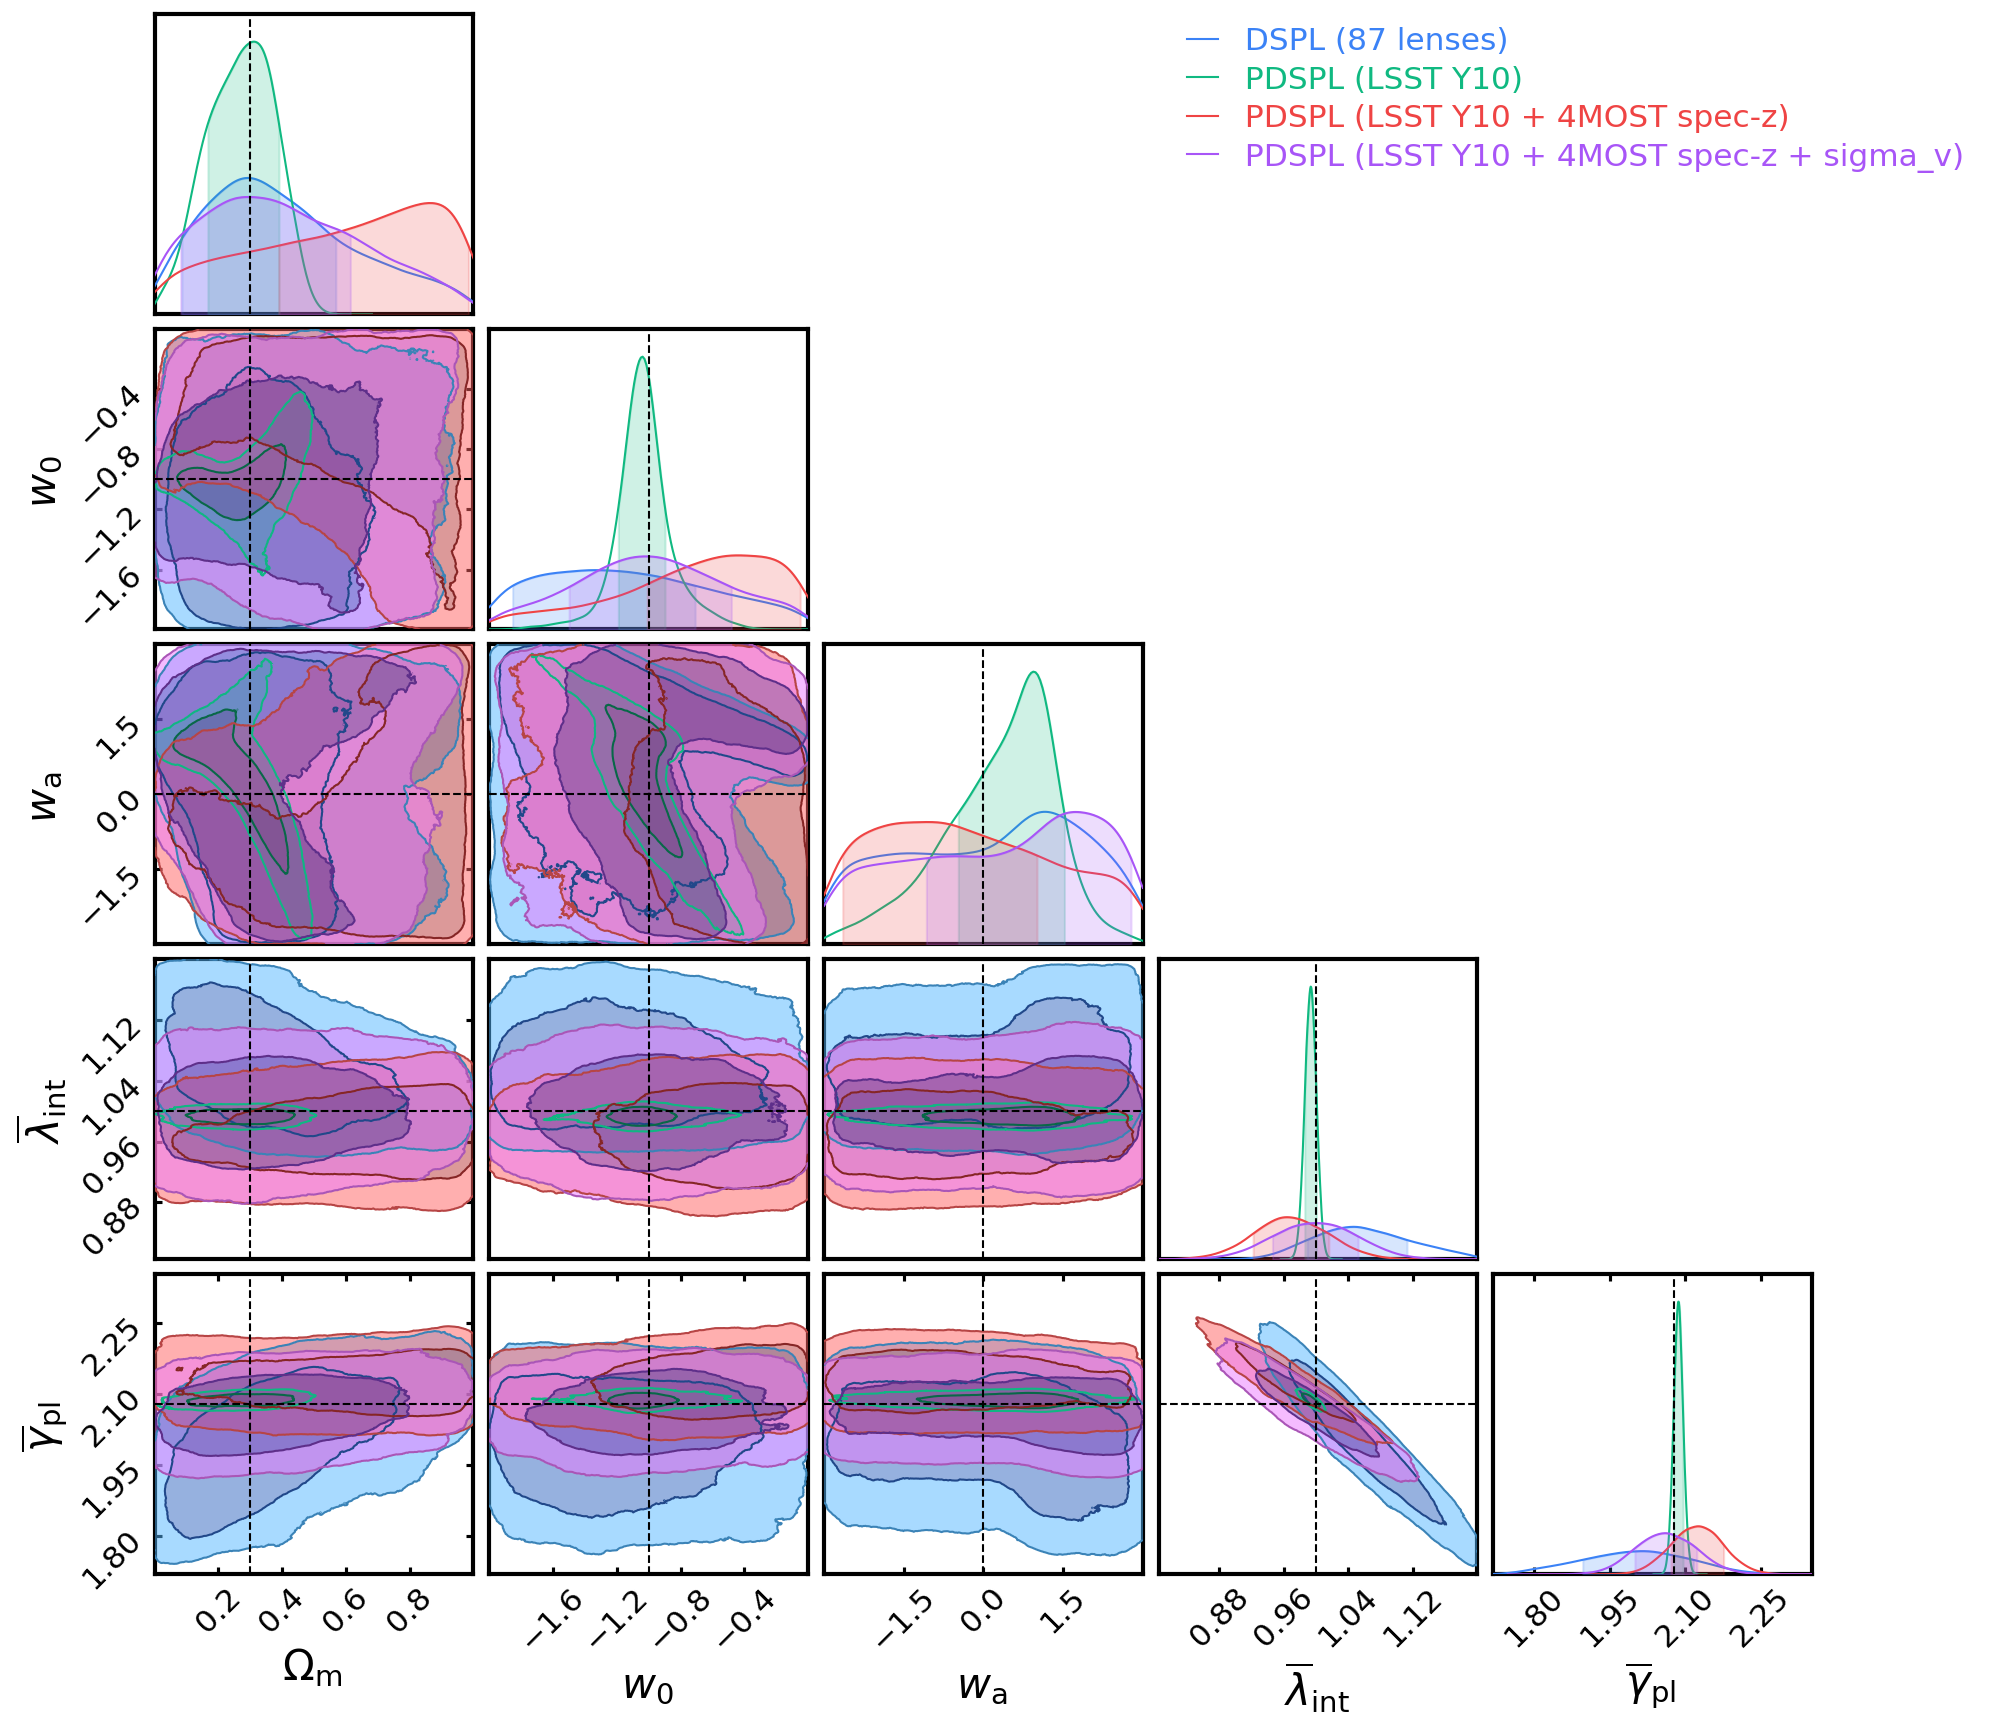

In [43]:
consumer = ChainConsumer()

for key in ['DSPL', 'lsst_y10', 'lsst_4most_spec-z', 'lsst_4most_spec-z_sigma_v']:
    chain = forecast_samples[key]['ChainConsumer-Chain']
    consumer.add_chain(chain)

# add truth values
consumer.add_truth(
    Truth(
    location = {
        r"$\Omega_{\rm m}$": om_true,
        r"$w_0$": w0_true,
        r"$w_{\rm a}$": wa_true,
        r"$\overline{\lambda}_{\rm int}$": lambda_mst_mean,
        r"$\overline{\gamma}_{\rm pl}$": gamma_pl_mean,
        # r"$\sigma(\gamma_{\rm pl, global})$": gamma_pl_sigma,
    }
)
)

##### configure plot settings

# extents = {
#                 r"$w_0$": [-2, 0],
#                 r"$w_{\rm a}$": [-3, 3],
#                 r"$\Omega_{\rm m}$": [0.1, 0.5],
#                 r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
#                 r"$\overline{\gamma}_{\rm pl}$": [1.5, 2.5],
#                 # r"$\sigma(\gamma_{\rm pl, global})$": [0.0, 0.32],
#             }

consumer.set_plot_config(
        PlotConfig(
            sigmas=[1, 2],
            # extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
    )

#### Plot and save the forecast results
fig = consumer.plotter.plot(
    columns=[
            '$\\Omega_{\\rm m}$',
            '$w_0$',
            '$w_{\\rm a}$',
            '$\\overline{\\lambda}_{\\rm int}$',
            '$\\overline{\\gamma}_{\\rm pl}$',
            # '$\\sigma(\\gamma_{\\rm pl, global})$'
            ],
    # figsize=(figure_width_inches * 0.8, figure_width_inches * 0.8),
)

# fig.savefig(os.path.join(FIGURES_DIR, "forecast_w0waCDM_all_samples.png"), dpi=300)
fig.savefig(os.path.join(FIGURES_DIR, "forecast_w0waCDM_all_samples.pdf"))

Parameter $w_{\rm a}$ in chain DSPL (87 lenses) is not constrained


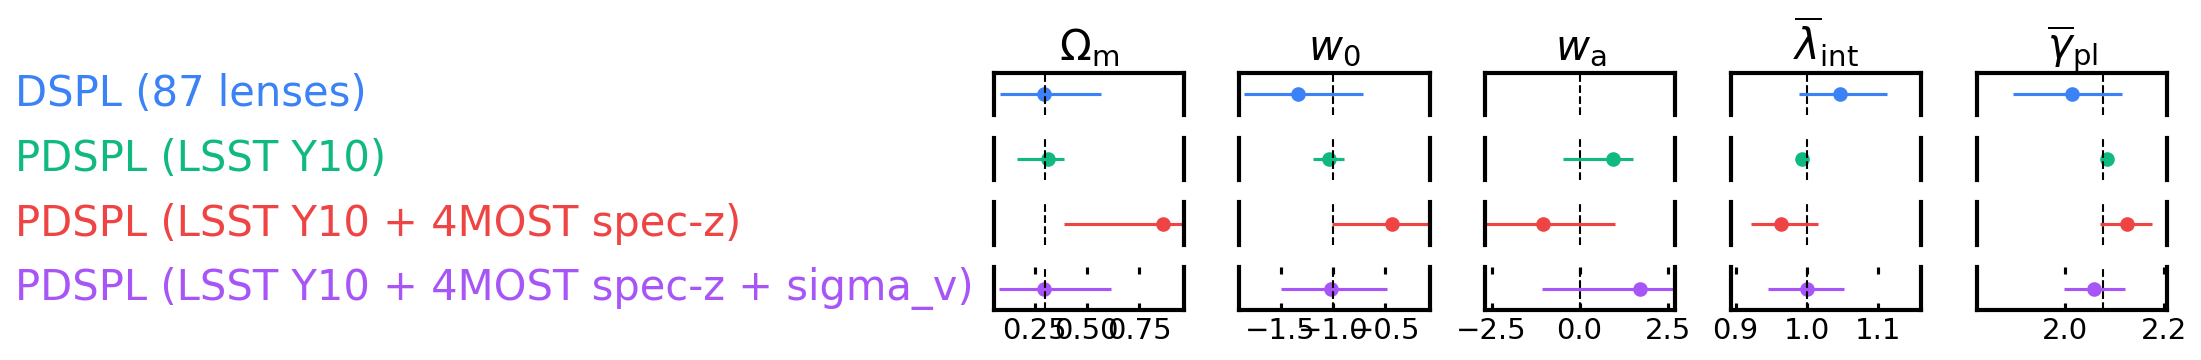

In [44]:
fig = consumer.plotter.plot_summary(errorbar=True);
fig.tight_layout()

In [25]:
latex_table = consumer.analysis.get_latex_table()
print(latex_table)

Parameter $w_{\rm a}$ in chain DSPL (87 lenses) is not constrained
Parameter $w_{\rm a}$ in chain PDSPL (LSST Y10 + 4MOST spec-z + sigma_v) is not constrained


\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{cccccc}
        \hline
		Model & $\Omega_{\rm m}$ & $w_0$ & $w_{\rm a}$ & $\overline{\lambda}_{\rm int}$ & $\overline{\gamma}_{\rm pl}$ \\ 
		\hline
		DSPL (87 lenses) & $0.28^{+0.29}_{-0.20}$ & $-1.35^{+0.61}_{-0.55}$ &  & $1.051^{+0.061}_{-0.062}$ & $2.019^{+0.097}_{-0.121}$ \\ 
		PDSPL (LSST SINGLE) & $0.422^{+0.071}_{-0.149}$ & $-1.01^{+0.25}_{-0.21}$ & $0.91^{+0.57}_{-2.27}$ & $\left( 1003.6^{+7.1}_{-6.4} \right) \times 10^{-3}$ & $2.085^{+0.012}_{-0.011}$ \\ 
		PDSPL (LSST Y10) & $0.316^{+0.073}_{-0.147}$ & $-1.03^{+0.13}_{-0.16}$ & $1.00^{+0.50}_{-1.46}$ & $\left( 993.5^{+6.8}_{-7.5} \right) \times 10^{-3}$ & $\left( 2085.8^{+9.5}_{-9.3} \right) \times 10^{-3}$ \\ 
		PDSPL (LSST Y10 + 4MOST spec-z) & $0.88^{+0.12}_{-0.48}$ & $-0.45^{+0.42}_{-0.53}$ & $-0.8^{+1.8}_{-2.0}$ & $0.959^{+0.056}_{-0.037}$ & $2.128^{+0.047}_{-0.056}$ \\ 
		PDSPL (LSST Y10 + 4MOST spec-z + sigma_v) & $0.25^{+0.36

Parameter $w_{\rm a}$ in chain PDSPL (LSST Y10 + 4MOST spec-z + sigma_v) is not constrained


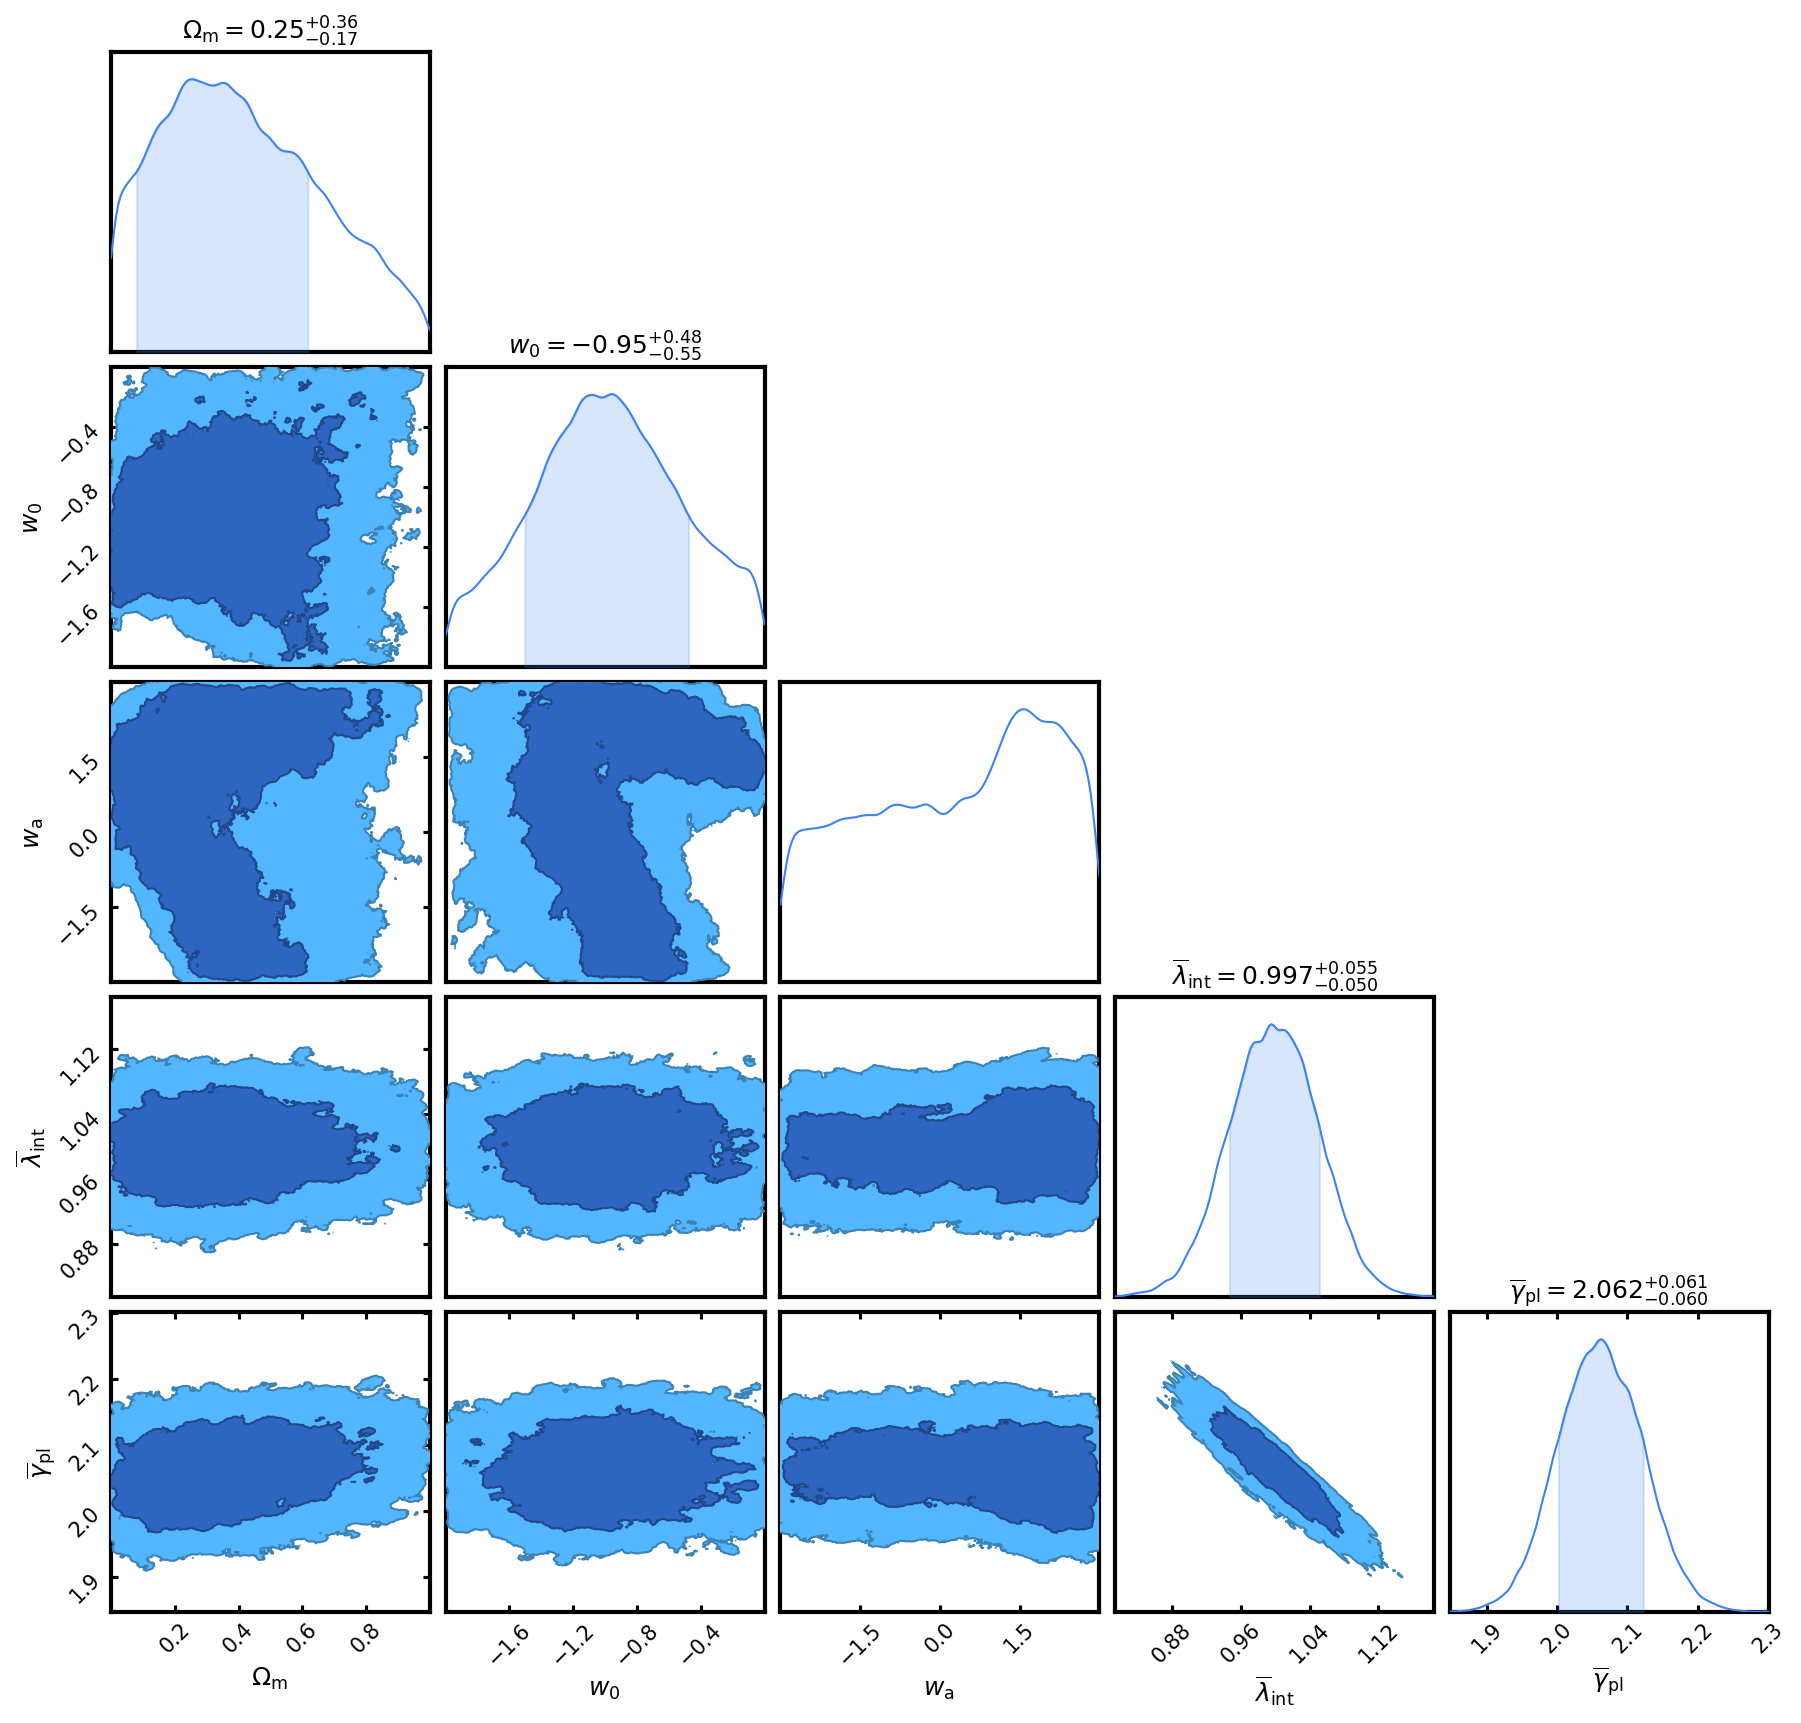

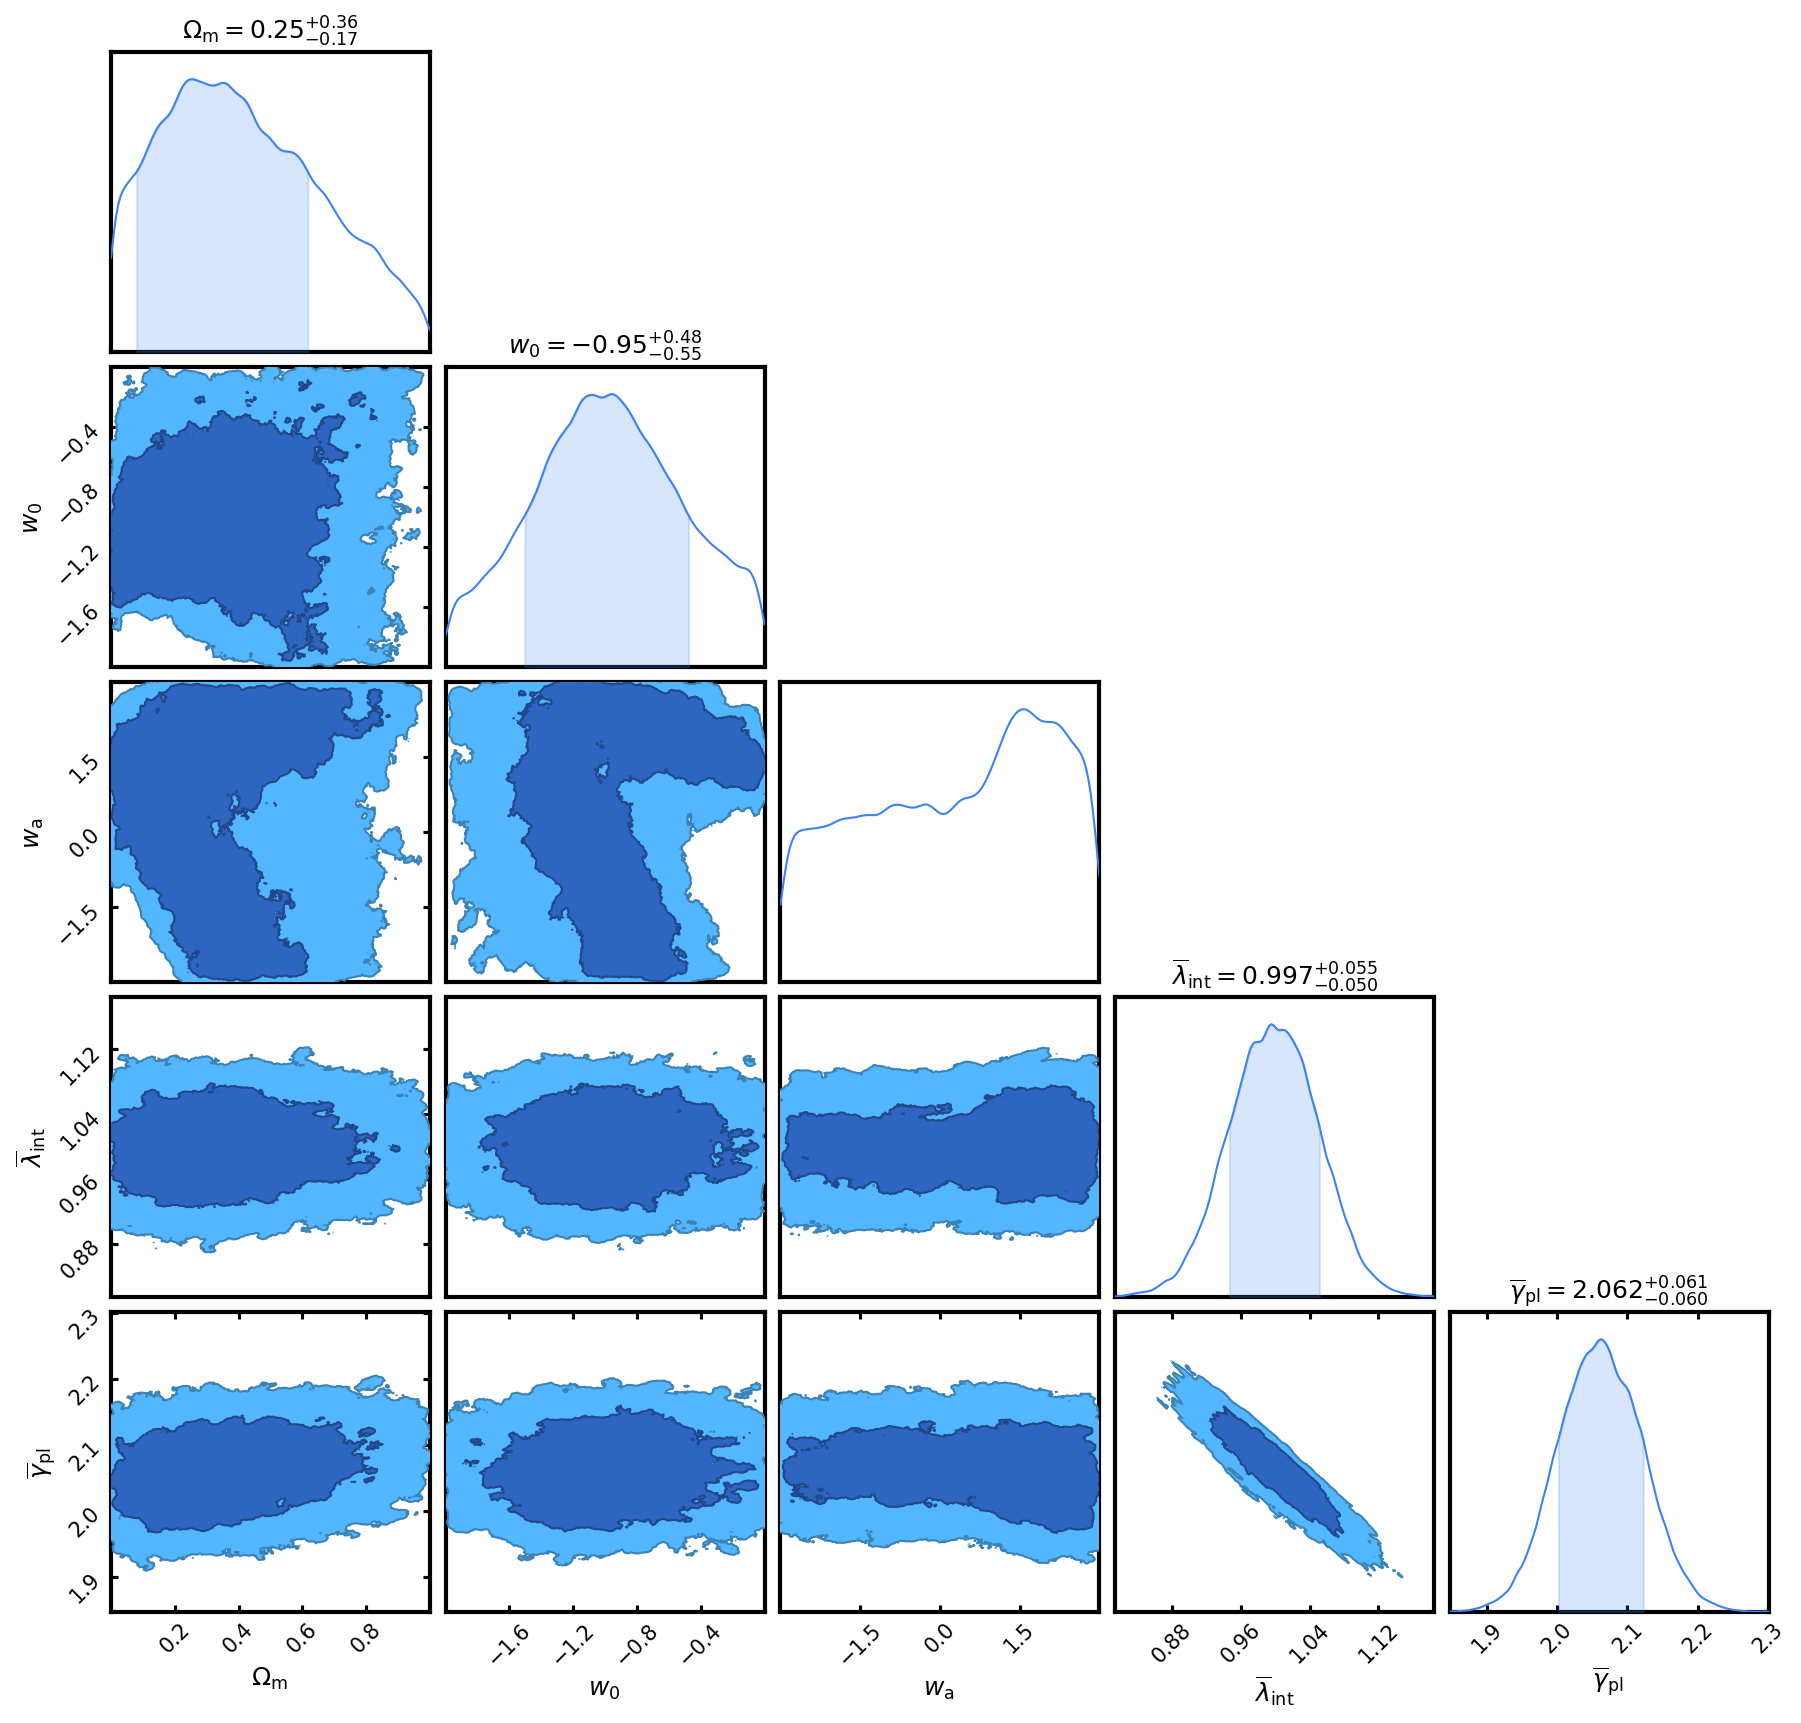

In [27]:
consumer = ChainConsumer()
consumer.add_chain(forecast_samples['lsst_4most_spec-z_sigma_v']['ChainConsumer-Chain'])
consumer.plotter.plot()

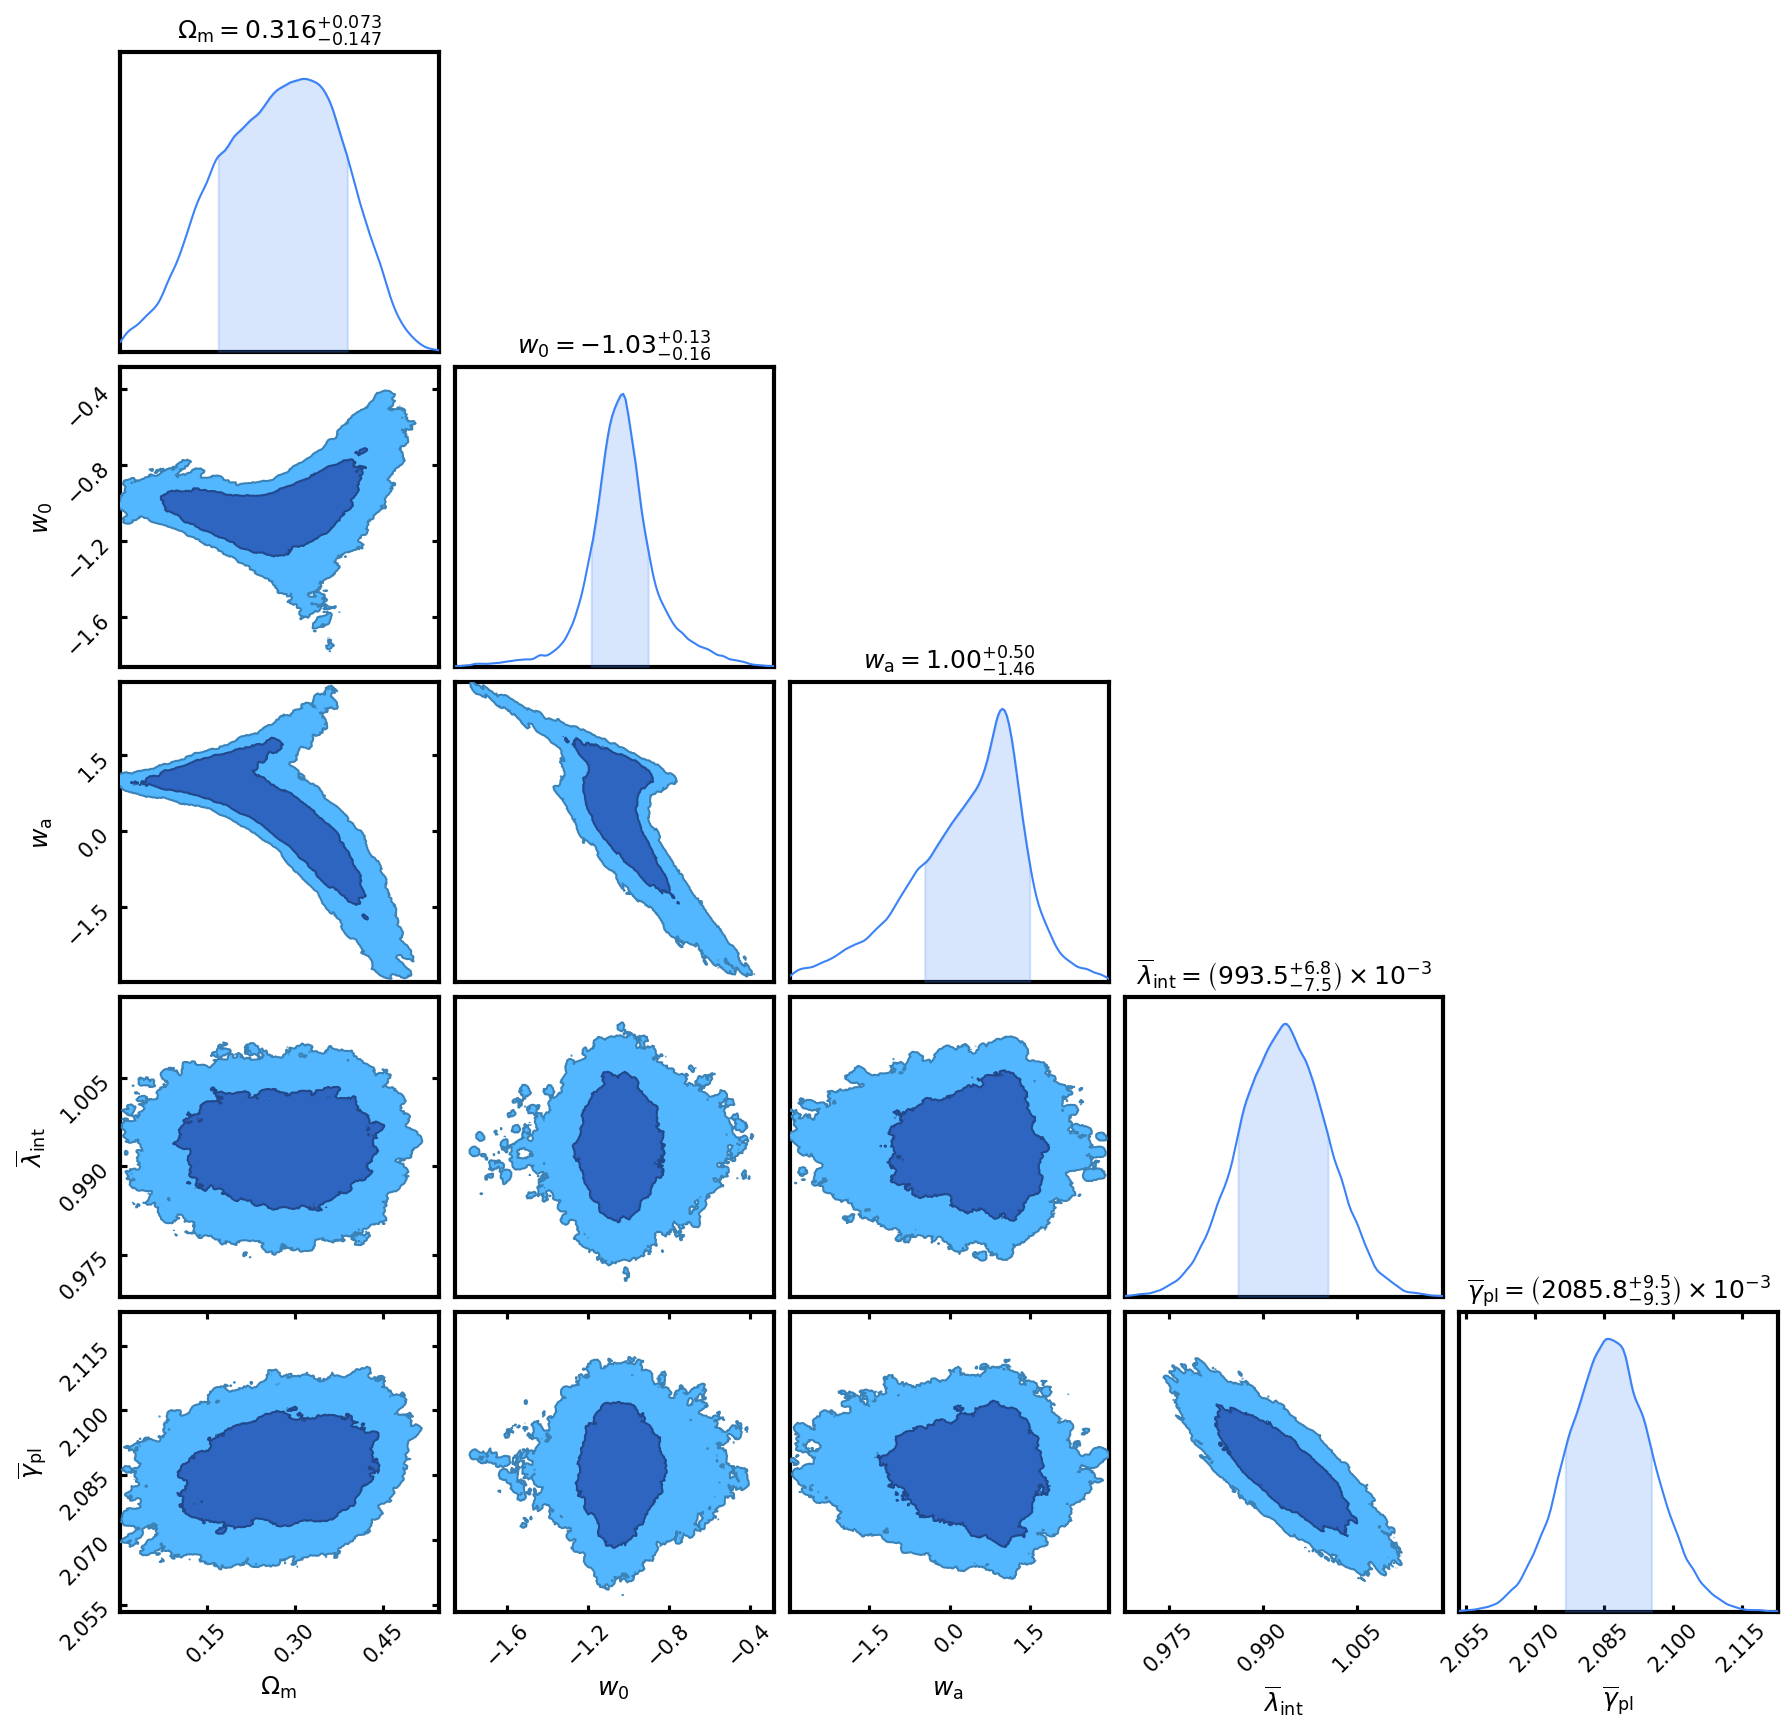

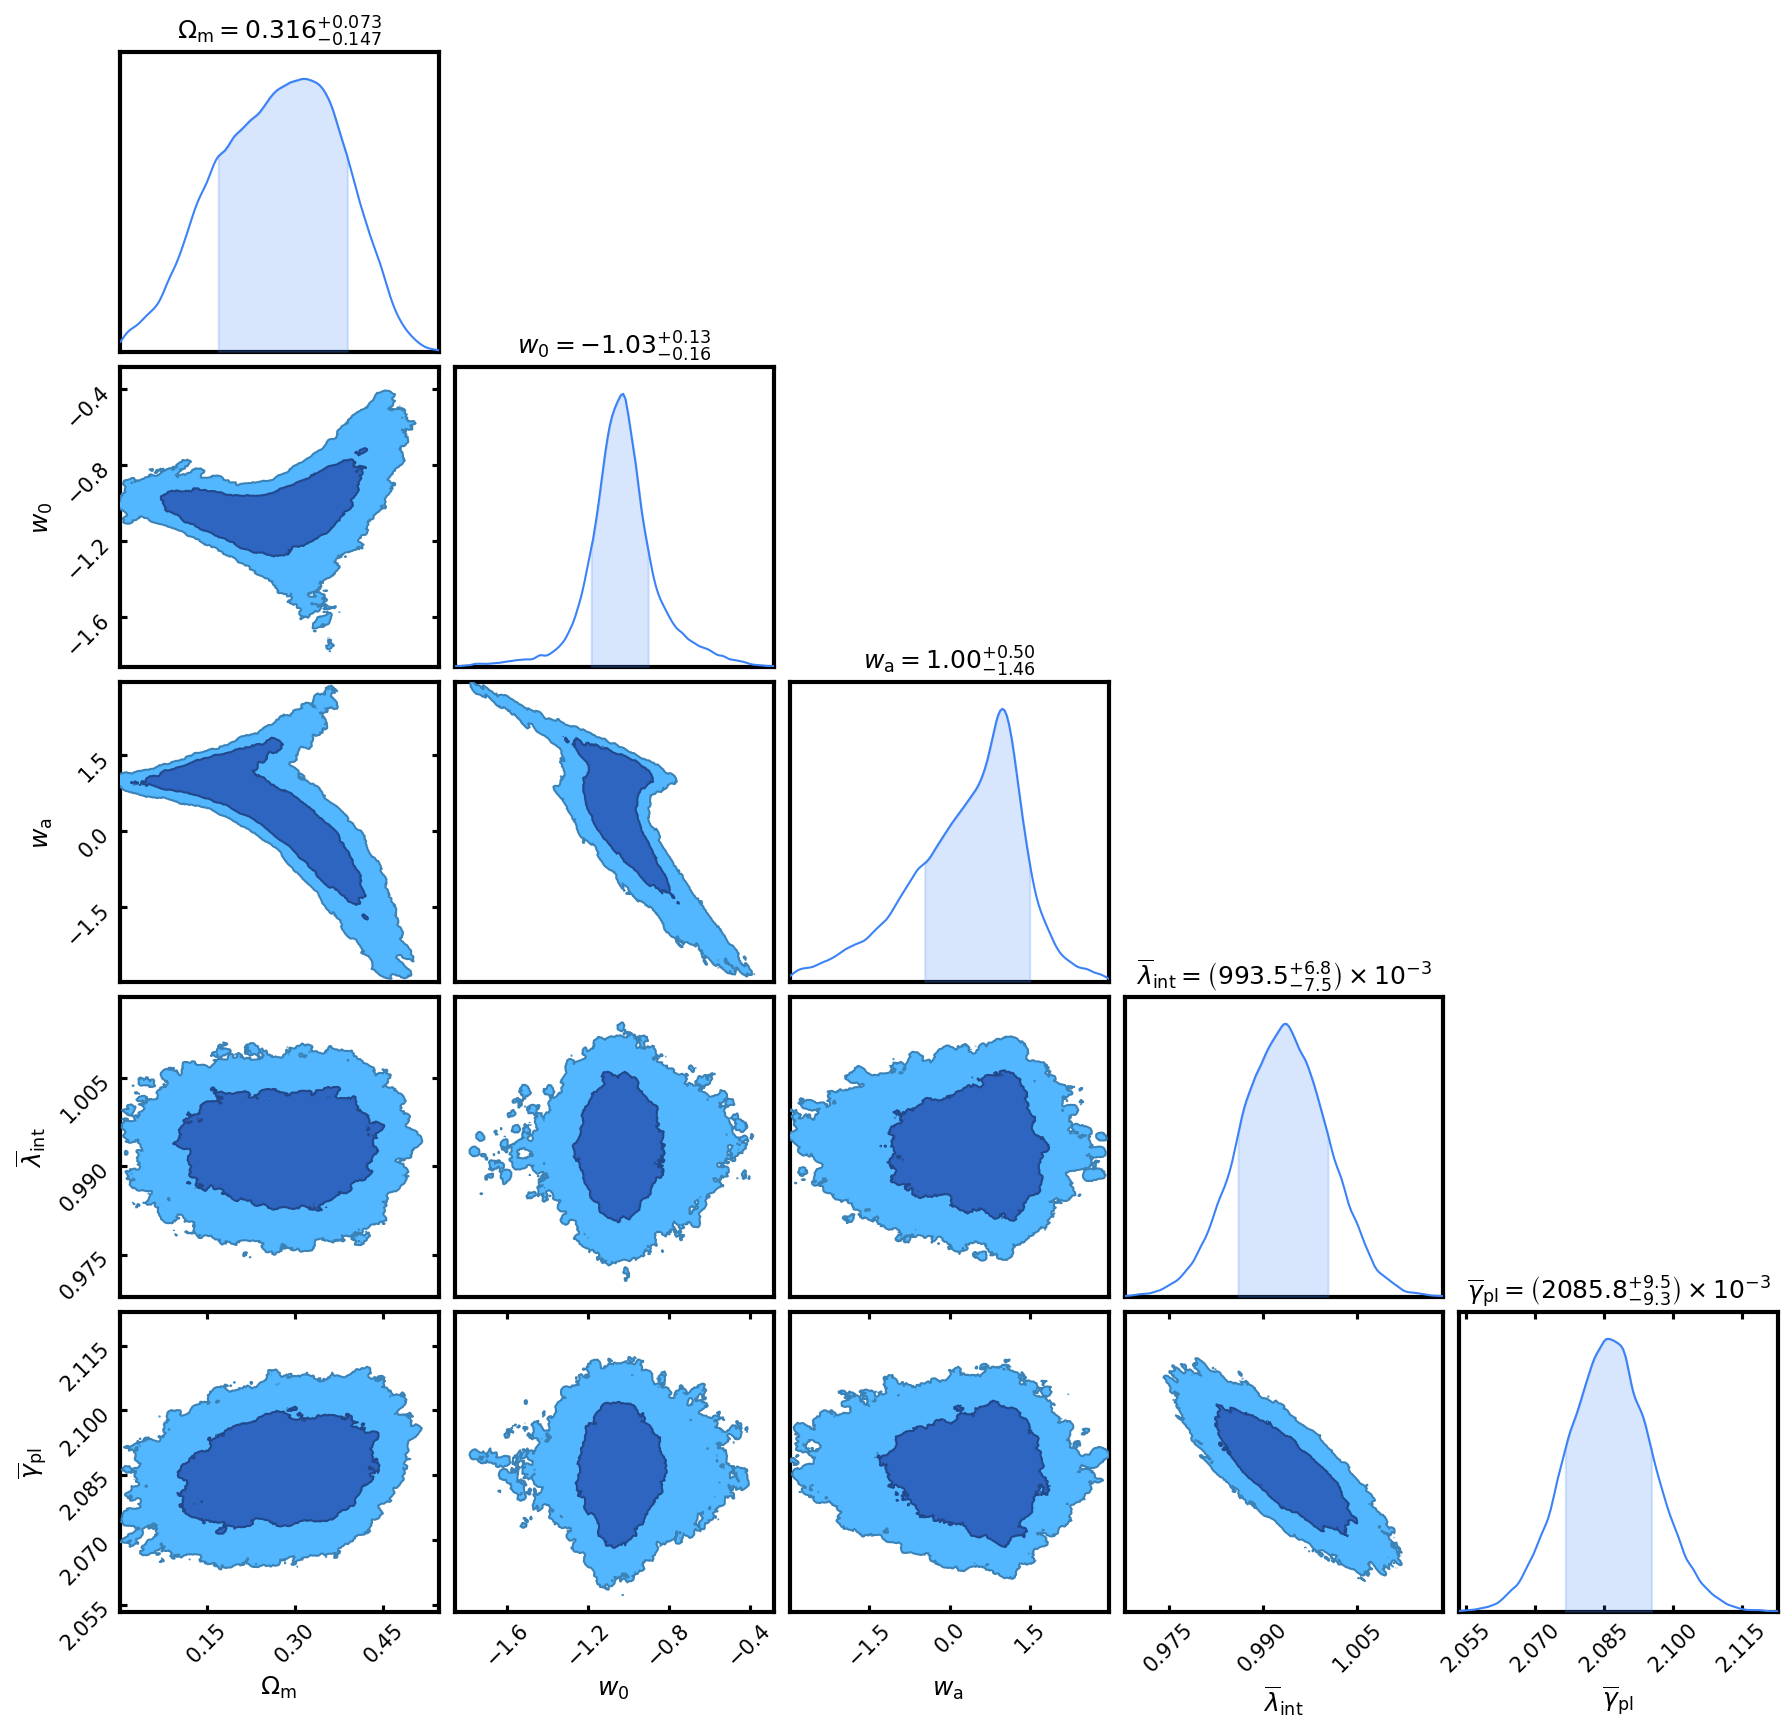

In [26]:
consumer = ChainConsumer()
consumer.add_chain(forecast_samples['lsst_y10']['ChainConsumer-Chain'])
consumer.plotter.plot()